# Publishing openEO workflow as a web service

This notebook explains how you can make your openEO algorithm available to interested users in an easy manner.

While you can of course distribute your source code or process graphs as open source (which is always recommendable), this has the drawback that you won't be able to update any local copies that somebody has made.

This guide explains how to expose your algorithm as a new openEO process, that can then be invoked very easily by others. You will also be able to advertise your
process on a discovery portal, so that others can easily find your work.

## An algorithm to start from

We'll need an existing openEO workflow that you want to publish. In this guide, we'll use a very simple EVI script, usually your algorithm will be more complex. Note that your algorithm does not have to be fully production
ready and mature before you expose it: sharing prototypes can sometimes be helpful to find interested users, and you can clearly indicate the quality level on the portal:

https://docs.terrascope.be/#/Developers/Marketplace/Start?id=service-maturity-levels


The table below provides an overview of the different maturity levels that are applied within the Marketplace.

| Level | Description |
| --- | --- |
| _**Prototype**_ | Service is provided ‘as-is’, with a short description and possibly a reference to what it tries to implement (scientific paper, well known metric, …) |
| _**Incubating**_ | Quality of the service is documented with example requests (sets of parameters) and the corresponding output, as well as the resources required to generate that output. Allowing interested users to self-assess whether this service is suitable for usage. |
| _**Validated**_ | The service is validated, and validation results are available.
| _**Operational**_ | The service has been shown to be fit for larger scale production and integration in operational systems. Rules for estimating resource usage are available, or a unit cost is established. (€ per km², € per request, ...) |







## openEO UDP's

To make a service available to your users, you will want to replace certain fixed values in your process graph with parameters that can be set by the user of your process.
Detailed documentation on this can be found here, but we'll also go through a few steps in this notebook:

https://open-eo.github.io/openeo-python-client/udp.html


The only limitation for this approach, is that your workflow needs to be defined as a single process graph. So workflows that require multiple openEO invocations or complex parameter preprocessing won't work yet. Of course, thanks to the flexibility of openEO, and the ability to include custom code as UDF's, a lot of algorithms can already be defined in a single openEO graph.




https://github.com/VITObelgium/notebook-samples/blob/master/Terrascope/Beginner/OpenEO_CropCalendarService.ipynb



In [15]:
import openeo
from openeo.api.process import Parameter

connection = openeo.connect("openeo.vito.be")

In [16]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.vito.be/openeo/1.1/' with BearerAuth>

In [12]:
DATE_DESCRIPTION = """Left-closed temporal interval, i.e. an array with exactly two elements:\n\n1. The first element is the start of the temporal interval. The specified instance in time is **included** in the interval.\n2. The second element is the end of the temporal interval. The specified instance in time is **excluded** from the interval.\n\nThe specified temporal strings follow [RFC 3339](https://www.rfc-editor.org/rfc/rfc3339.html). Also supports open intervals by setting one of the boundaries to `null`, but never both."""
DATE_SCHEMA = {
    "type": "array",
    "subtype": "temporal-interval",
    "minItems": 2,
    "maxItems": 2,
    "items": {
        "anyOf": [
            {
                "type": "string",
                "format": "date-time",
                "subtype": "date-time"
            },
            {
                "type": "string",
                "format": "date",
                "subtype": "date"
            },
            {
                "type": "string",
                "subtype": "year",
                "minLength": 4,
                "maxLength": 4,
                "pattern": "^\\d{4}$"
            },
            {
                "type": "null"
            }
        ]
    },
    "examples": [
        [
            "2015-01-01T00:00:00Z",
            "2016-01-01T00:00:00Z"
        ],
        [
            "2015-01-01",
            "2016-01-01"
        ]
    ]
}

date_param =  Parameter(
    name="date",
    description=DATE_DESCRIPTION,
    schema=DATE_SCHEMA
)

polygon_param =  Parameter(
    name="polygon",
    description="Geographical extent for the EVI input",
    schema={"type": "object", "subtype": "geojson"}
)

Now we can start the implementation of the actual service. Based on the different functions, provided by the OpenEO python client, the following actions are executed:

1. Load in the TerraScope Sentinel 2 collection, select the images that were taken on the date specified by the *date_param* parameter and only select the relevant bands.
2. Apply an additional filtering to only select the data that is matching the polygon defined by the *polygon_param* parameter.
3. Extract the band information from the resulting datacube.
4. Use the bands to calculate resulting EVI product based on a given formula

In [17]:
sentinel2_data_cube = connection.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=date_param,
    bands=["B02", "B04", "B08"]
)

sentinel2_data_cube = sentinel2_data_cube.filter_spatial(polygon_param)

B02 = sentinel2_data_cube.band('B02')
B04 = sentinel2_data_cube.band('B04')
B08 = sentinel2_data_cube.band('B08')

evi_cube = (2.5 * (B08 - B04)) / ((B08 + 6.0 * B04 - 7.5 * B02) + 1.0)

## Publish the service in OpenEO
Now that we have implemented our service, we can publish the service within OpenEO. This will result in a URL that enables you to share the service to other OpenEO users.

**Remark** - This will not publish the service to the marketplace. However, this step is required to publish the service on the marketplace as it is important that your service is available to other OpenEO users.

In [35]:
process_name = "EVI"
connection.save_user_defined_process(
    user_defined_process_id=process_name,
    process_graph=evi_cube.graph,
    parameters=[date_param,polygon_param],
    public=True
)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) graph. (Use `DataCube.flat_graph()` instead.) -- Deprecated since version 0.9.0.
  after removing the cwd from sys.path.


## Let's try it out!
Now that we have created and published our service, we can test it to see if it working!

We start by defining our input parameters

In [20]:
output_file = "evi.tiff"
polygon =  {"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[5.169965489314347,51.250572485731965],[5.1709813825271,51.248670823679106],[5.178575420851998,51.24673809898954],[5.179170926259544,51.24985398556541],[5.169965489314347,51.250572485731965]]]},"properties":{}}
date = ["2022-05-02","2022-05-06"]

Exec

In [21]:
evi_exec = connection.datacube_from_process("EVI", date=date, polygon=polygon)
evi_exec.download(output_file, format="GTIFF")

/data/users/Public/driesj/openeo/openeo-python-client/openeo/metadata.py:244: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


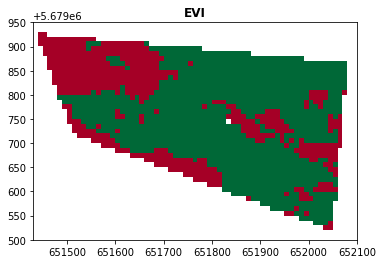

In [22]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show,show_hist
ds = rasterio.open(output_file)
fig = plt.subplots(1,1, figsize=(9, 4))
show(ds,cmap=plt.cm.RdYlGn,title='EVI', vmin=-1, vmax=1)

## Publishing your service online

We now want to also add this service to the marketplace. The documentation for that can be found here:

https://docs.terrascope.be/#/Developers/Marketplace/Services?id=create-a-new-service



One requirement for publishing, is to know a public url for your service. You'll need to know your username to construct the link:
https://docs.terrascope.be/#/Developers/Marketplace/Services?id=create-a-link-to-directly-execute-your-service


In [27]:
username = connection.describe_account()['user_id']
username

'dfa678cb9ab17f65d4f025e30fac5e0d90116176e44fd17d703419322747cbbd@egi.eu'

If your UDP registration succeeded, this link should point to it:

In [29]:
udp_url = f"https://openeo.vito.be/openeo/1.0/processes/u:{username}/{process_name}"
udp_url

'https://openeo.vito.be/openeo/1.0/processes/u:dfa678cb9ab17f65d4f025e30fac5e0d90116176e44fd17d703419322747cbbd@egi.eu/EVI'

Or we can open our service in the openEO web editor, this is convenient for users that want to test without scripting:

In [34]:
editor_url= f"https://editor.openeo.org/?server=https://openeo.vito.be&namespaces={username}&process={process_name}&edit-node=1"
editor_url

'https://editor.openeo.org/?server=https://openeo.vito.be&namespaces=dfa678cb9ab17f65d4f025e30fac5e0d90116176e44fd17d703419322747cbbd@egi.eu&process=EVI&edit-node=1'